In [1]:
# Installation did not work with pip
# %%sh
# conda install -c conda-forge shap

In [2]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html
import numpy as np
import pandas as pd

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import eli5
from eli5.sklearn import PermutationImportance
import shap

import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image

/home/luisrodrigues/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/luisrodrigues/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# ===========================================================================================
# The KDD Cup ‘99 dataset was created by processing the tcpdump portions of the 1998 DARPA 
# Intrusion Detection System (IDS) Evaluation dataset, created by MIT Lincoln Lab [1]. The 
# artificial data (described on the dataset’s homepage) was generated using a closed network 
# and hand-injected attacks to produce a large number of different types of attack with normal 
# activity in the background. 
#
# FEATURES:
#        duration: continuous      
#        protocol_type: symbolic      
#        service: symbolic      
#        flag: symbolic      
#        src_bytes: continuous      
#        dst_bytes: continuous      
#        land: symbolic      
#        wrong_fragment: continuous      
#        urgent: continuous      
#        hot: continuous      
#        num_failed_logins: continuous      
#        logged_in: symbolic      
#        num_compromised: continuous      
#        root_shell: continuous      
#        su_attempted: continuous      
#        num_root: continuous      
#        num_file_creations: continuous      
#        num_shells: continuous      
#        num_access_files: continuous      
#        num_outbound_cmds: continuous      
#        is_host_login: symbolic      
#        is_guest_login: symbolic      
#        count: continuous      
#        srv_count: continuous      
#        serror_rate: continuous      
#        srv_serror_rate: continuous      
#        rerror_rate: continuous      
#        srv_rerror_rate: continuous      
#        same_srv_rate: continuous      
#        diff_srv_rate: continuous      
#        srv_diff_host_rate: continuous      
#        dst_host_count: continuous      
#        dst_host_srv_count: continuous      
#        dst_host_same_srv_rate: continuous      
#        dst_host_diff_srv_rate: continuous      
#        dst_host_same_src_port_rate: continuous      
#        dst_host_srv_diff_host_rate: continuous      
#        dst_host_serror_rate: continuous      
#        dst_host_srv_serror_rate: continuous      
#        dst_host_rerror_rate: continuous      
#        dst_host_srv_rerror_rate: continuous      
#
# TARGET:
#        Connection type:
#            b'back.': 19 samples
#            b'guess_passwd.': 3 samples
#            b'ipsweep.': 9 samples
#            b'neptune.': 943 samples
#            b'nmap.': 3 samples
#            b'normal.': 97278 samples
#            b'pod.': 1 samples
#            b'portsweep.': 7 samples
#            b'satan.': 14 samples
#            b'smurf.': 2361 samples
#            b'teardrop.': 9 samples
#            b'warezclient.': 8 samples
#
# GOAL:
#            The competition task was to build a network intrusion detector, a predictive 
#            model capable of distinguishing between ``bad'' connections, called intrusions 
#            or attacks, and ``good'' normal connections
#
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_kddcup99.html#sklearn.datasets.fetch_kddcup99
# https://scikit-learn.org/stable/datasets/index.html#kddcup99-dataset
# https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# ===========================================================================================

RANDOM_STATE = 42

data = datasets.fetch_kddcup99(subset='SA')

classes_to_use = [b'normal.', b'smurf.']
class_names = ['normal', 'attack']
# mask_sample_to_use = [y in classes_to_use for y in data.target]
mask_sample_to_use = [True for y in data.target]
X = data.data[mask_sample_to_use]
y_bytes = data.target[mask_sample_to_use]
# Convert the target to numeric form using the index
#y = np.array([classes_to_use.index(y_i) for y_i in y_bytes])
y = np.array([ 1 - (y_i==b'normal.') for y_i in y_bytes])

feature_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
categorical_feature_names = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
target_name = 'connection_type'

print('''Number of samples: {}'''.format(len(X)))
print('''Number of features: {}'''.format(X.shape[1]))
print('''Number of classes: {}'''.format(len(np.unique(y))))

dfData = pd.DataFrame(np.concatenate((X, y.reshape(1, len(y)).T), axis=1), columns=feature_names+[target_name])

dfData.head()

Number of samples: 100655
Number of features: 41
Number of classes: 2


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,1,0,0.11,0,0,0,0,0,0
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,1,0,0.05,0,0,0,0,0,0
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,1,0,0.03,0,0,0,0,0,0
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,1,0,0.03,0,0,0,0,0,0
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,1,0,0.02,0,0,0,0,0,0


In [4]:
# ===========================================================================================
# One hot encoder of categorical features
# ===========================================================================================

feature_names_oh = set(feature_names) - set(categorical_feature_names)
feature_names_oh = list(feature_names_oh)

X_oh = dfData[feature_names_oh].values

dfData_oh = dfData[feature_names_oh+[target_name]]

In [5]:
# ===========================================================================================
# Split data into train and test
# ===========================================================================================

test_size=0.30

X_train, X_test, y_train, y_test = train_test_split(X_oh, y, test_size=test_size, random_state=RANDOM_STATE)

dfData_train = pd.DataFrame(np.concatenate((X_train, y_train.reshape(1, len(y_train)).T), axis=1), columns=feature_names_oh+[target_name])
dfData_test  = pd.DataFrame(np.concatenate((X_test , y_test .reshape(1, len(y_test )).T), axis=1), columns=feature_names_oh+[target_name])

In [6]:
# ===========================================================================================
# Decision Tree Classifier
# https://scikit-learn.org/stable/modules/tree.html#tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# ===========================================================================================

max_depth = 3
min_samples_split = 30
dtc = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, criterion='entropy', random_state=RANDOM_STATE)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [7]:
# The accuracy is the fraction of correctly classified samples
accuracy = accuracy_score(y_pred,y_test)
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp 
# the number of false positives. The precision is intuitively the ability of the classifier 
# not to label as positive a sample that is negative.
precision = precision_score(y_pred,y_test)
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the 
# number of false negatives. The recall is intuitively the ability of the classifier to find 
# all the positive samples.
recall = recall_score(y_pred,y_test)
# The F1 score can be interpreted as a harmonic mean of the precision and recall. The formula 
# for the F1 score is: F1 = 2 * (precision * recall) / (precision + recall)
f1score = f1_score(y_pred,y_test)
# Provide metris for each class (positive and negative)
# precision, recall, fscore, support = precision_recall_fscore_support(y_pred,y_test)

print('''Metrics for Random Forest Classifier: ''' + 
      '''\n \t accuracy: {} \n\t precision: {} \n\t recall: {} \n\t f1score: {}''' 
      .format(accuracy, precision, recall, f1score))

Metrics for Random Forest Classifier: 
 	 accuracy: 0.9993707984236845 
	 precision: 0.9819277108433735 
	 recall: 0.9989785495403473 
	 f1score: 0.9903797468354429


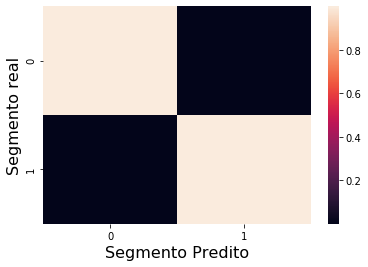

In [8]:
cm = confusion_matrix(y_pred,y_test,normalize='true')
plt.figure(figsize=(6,4))
ax = sns.heatmap(cm)
ax.set_xlabel("Segmento Predito",fontdict={"fontsize":16})
ax.set_ylabel("Segmento real",fontdict={"fontsize":16})
sns.set(font_scale = 1.5)

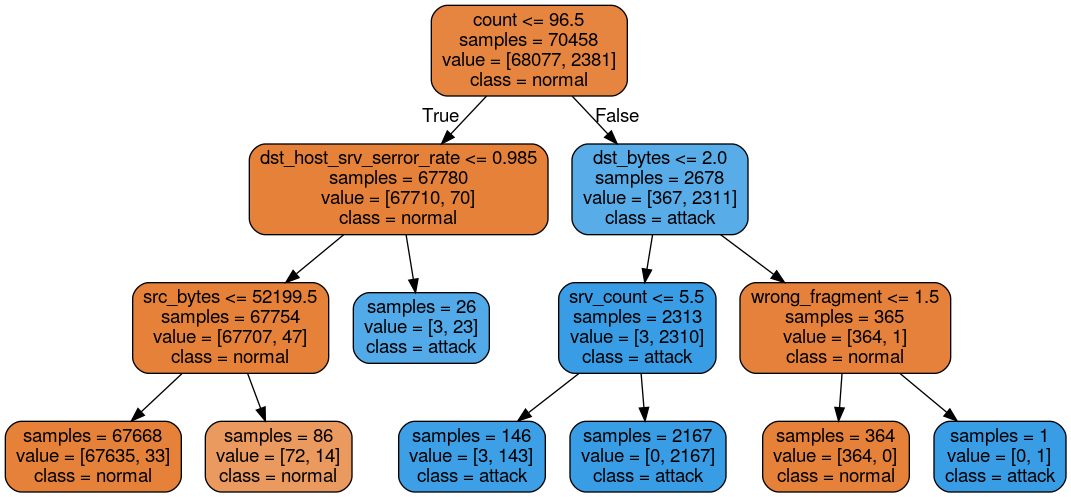

In [9]:
# ===========================================================================================
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
# https://www.kaggle.com/willkoehrsen/visualize-a-decision-tree-w-python-scikit-learn
# ===========================================================================================

dot_data = export_graphviz(dtc, 
               out_file=None,
               feature_names=feature_names_oh,
               class_names=class_names,
               precision=3,
               #fontsize=12,
               filled=True,
               rounded=True,
               proportion=False,
               impurity=False)

graph = pydotplus.graph_from_dot_data(dot_data)

'''
import collections
colors = ('lightblue', 'blue', 'green')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])
'''

fig_name = 'Figure/Decision_tree.png'

graph.write_png(fig_name)

Image(filename = fig_name)

In [10]:
def SortArrayByMetric(array, metric, reverse=False):
    arrayMetricSorted = sorted(zip(metric, array), reverse=reverse)
    metricSorted = [point[0] for point in arrayMetricSorted]
    arraySorted = [point[1] for point in arrayMetricSorted]
    return arraySorted, metricSorted

ArraySorted, MetricSorted = SortArrayByMetric(feature_names_oh, dtc.feature_importances_, reverse=True)

feature_importances = dict(zip(ArraySorted, MetricSorted))

for index, feat in enumerate(feature_importances):
    if(index < 9):
        print('''{}ª feature most important, with importance of {}, is {}'''.format(index+1, round(feature_importances[feat], 2), feat))

1ª feature most important, with importance of 0.87, is count
2ª feature most important, with importance of 0.1, is dst_bytes
3ª feature most important, with importance of 0.02, is dst_host_srv_serror_rate
4ª feature most important, with importance of 0.01, is src_bytes
5ª feature most important, with importance of 0.0, is srv_count
6ª feature most important, with importance of 0.0, is wrong_fragment
7ª feature most important, with importance of 0.0, is urgent
8ª feature most important, with importance of 0.0, is su_attempted
9ª feature most important, with importance of 0.0, is srv_serror_rate


In [11]:
# ===========================================================================================
# https://github.com/slundberg/shap
# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
# https://www.kaggle.com/dansbecker/shap-values
# https://shap.readthedocs.io/en/latest/
# ===========================================================================================

model = dtc

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model, model_output="raw", feature_perturbation="tree_path_dependent")
shap_values_train = explainer.shap_values(dfData_train[feature_names_oh])
shap_values_test  = explainer.shap_values(dfData_test [feature_names_oh])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


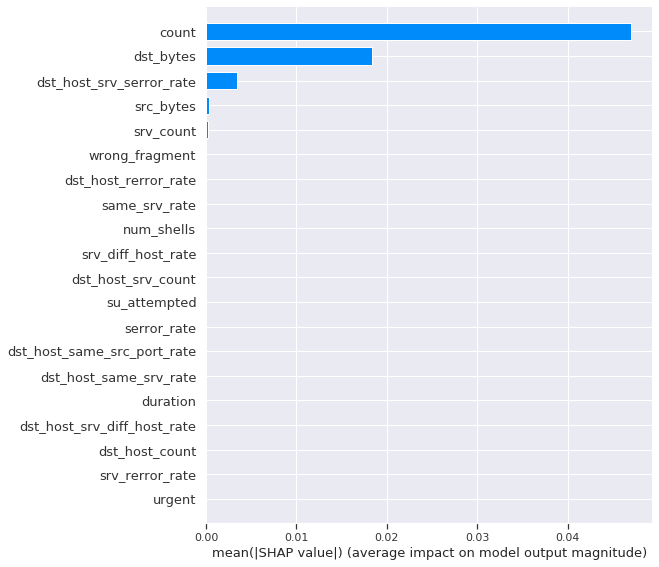

In [12]:
fig_name = 'Figure/Shap_mean_per_feature.png'
f = plt.figure()
shap.summary_plot(shap_values_train[1], dfData_train[feature_names_oh], plot_type="bar", show=False)
f.savefig(fig_name, bbox_inches='tight', dpi=600)

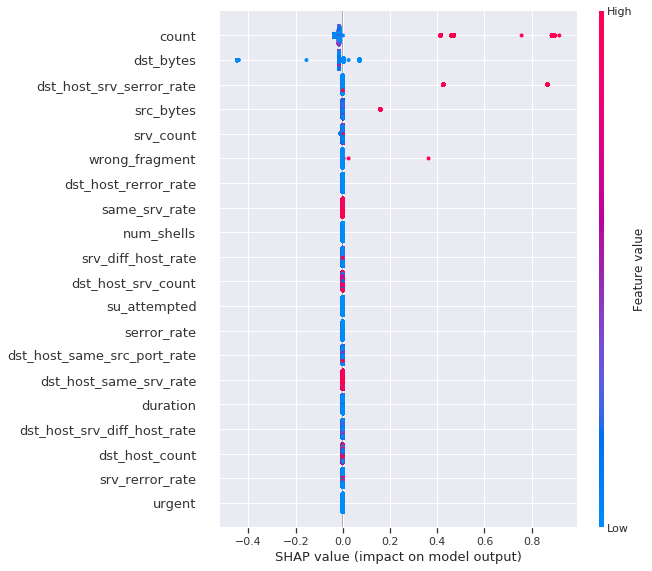

In [13]:
fig_name = 'Figure/Shap_values_per_feature.png'
f = plt.figure()
shap.summary_plot(shap_values_train[1], dfData_train[feature_names_oh], show=False)
f.savefig(fig_name, bbox_inches='tight', dpi=600)

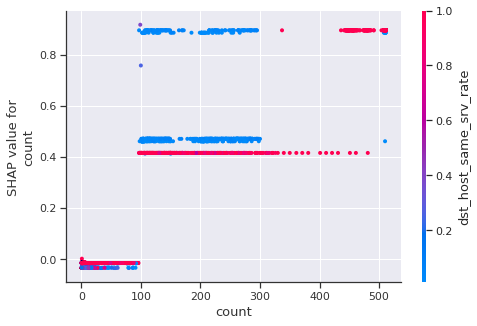

In [14]:
feature = list(feature_importances.keys())[0]
fig_name = 'Figure/Shap_dependecePlot_for_' + feature + '.png'
shap.dependence_plot(feature, shap_values_train[1], dfData_train[feature_names_oh], show=False)
f = plt.gcf()
f.savefig(fig_name, bbox_inches='tight', dpi=600)

Predicted probability of sample belonging to the positive class: 1.00 



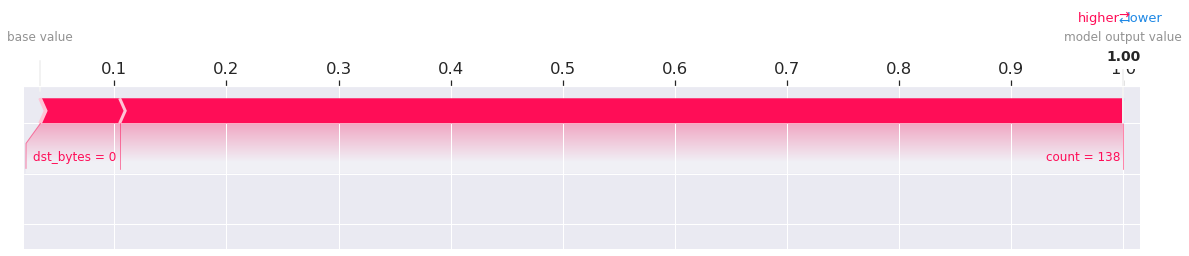

In [15]:
i = 0
mask_positive_class = [True if y_i==1 else False for y_i in y_test]
dfData_test_i = dfData_test[mask_positive_class].iloc[[i]]

print('Predicted probability of sample belonging to the positive class: %.2f \n' % (model.predict_proba(dfData_test_i[feature_names_oh])[0][1]))

shap_values_test_i  = explainer.shap_values(dfData_test_i[feature_names_oh])

# load JS visualization code to notebook
fig_name = 'Figure/Shap_values_for_a_prediction.png'

#shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_test_i[1], dfData_test_i[feature_names_oh], show=False, matplotlib=True)

plt.savefig(fig_name, bbox_inches='tight', dpi=600)

In [16]:
# ===========================================================================================
# Random Forest Classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# ===========================================================================================

#max_depth = 3
#min_samples_split = 30
n_estimators = 10
rfc = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split, n_estimators=n_estimators, criterion='entropy', random_state=RANDOM_STATE)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_pred,y_test)
precision = precision_score(y_pred,y_test)
recall = recall_score(y_pred,y_test)
f1score = f1_score(y_pred,y_test)
print('''Metrics for Random Forest Classifier: ''' + 
      '''\n \t accuracy: {} \n\t precision: {} \n\t recall: {} \n\t f1score: {}''' 
      .format(accuracy, precision, recall, f1score))

Metrics for Random Forest Classifier: 
 	 accuracy: 0.9994701460409975 
	 precision: 0.9839357429718876 
	 recall: 1.0 
	 f1score: 0.9919028340080972


In [17]:
# ===========================================================================================
# Gradient Boosting Classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
# ===========================================================================================

#max_depth = 3
#min_samples_split = 30
n_estimators = 10
gbc = GradientBoostingClassifier(max_depth=max_depth, min_samples_split=min_samples_split, n_estimators=n_estimators, criterion='mse', loss='deviance', learning_rate=0.1, random_state=RANDOM_STATE)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

accuracy = accuracy_score(y_pred,y_test)
precision = precision_score(y_pred,y_test)
recall = recall_score(y_pred,y_test)
f1score = f1_score(y_pred,y_test)
print('''Metrics for Gradient Boosting Classifier: ''' + 
      '''\n \t accuracy: {} \n\t precision: {} \n\t recall: {} \n\t f1score: {}''' 
      .format(accuracy, precision, recall, f1score))

Metrics for Gradient Boosting Classifier: 
 	 accuracy: 0.9994370301685598 
	 precision: 0.9829317269076305 
	 recall: 1.0 
	 f1score: 0.9913924050632912


In [18]:
# ===========================================================================================
# Logistic Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# ===========================================================================================

lgc = LogisticRegression(fit_intercept=True, solver='saga', penalty='elasticnet', l1_ratio=0.9, C=1e-4, max_iter=1e3, random_state=RANDOM_STATE)
lgc.fit(X_train, y_train)
y_pred = lgc.predict(X_test)

accuracy = accuracy_score(y_pred,y_test)
precision = precision_score(y_pred,y_test)
recall = recall_score(y_pred,y_test)
f1score = f1_score(y_pred,y_test)
print('''Metrics for Logistic Regression Classifier: ''' + 
      '''\n \t accuracy: {} \n\t precision: {} \n\t recall: {} \n\t f1score: {}''' 
      .format(accuracy, precision, recall, f1score))

Metrics for Logistic Regression Classifier: 
 	 accuracy: 0.9670165910520913 
	 precision: 0.0 
	 recall: 0.0 
	 f1score: 0.0


The max_iter was reached which means the coef_ did not converge
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [19]:
# ===========================================================================================
# Support Vector Machines Classifier
# https://scikit-learn.org/stable/modules/svm.html
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
# ===========================================================================================

svm = SVC(kernel='linear', C=1e-2, max_iter=1e5, random_state=RANDOM_STATE)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_pred,y_test)
precision = precision_score(y_pred,y_test)
recall = recall_score(y_pred,y_test)
f1score = f1_score(y_pred,y_test)
print('''Metrics for SVM Classifier: ''' + 
      '''\n \t accuracy: {} \n\t precision: {} \n\t recall: {} \n\t f1score: {}''' 
      .format(accuracy, precision, recall, f1score))

Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Metrics for SVM Classifier: 
 	 accuracy: 0.4111997880584164 
	 precision: 0.9949799196787149 
	 recall: 0.05280827027603112 
	 f1score: 0.10029349256148162


In [20]:
# ===========================================================================================
# Multi-layer Perceptron Classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# ===========================================================================================

sc = StandardScaler()
mlp = MLPClassifier(hidden_layer_sizes=(4,4), activation='logistic', learning_rate_init=0.01, learning_rate='invscaling', max_iter=500, random_state=RANDOM_STATE)
pl = make_pipeline(sc, mlp)
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)

accuracy = accuracy_score(y_pred,y_test)
precision = precision_score(y_pred,y_test)
recall = recall_score(y_pred,y_test)
f1score = f1_score(y_pred,y_test)
print('''Metrics for Multi-layer Perceptron Classifier: ''' + 
      '''\n \t accuracy: {} \n\t precision: {} \n\t recall: {} \n\t f1score: {}''' 
      .format(accuracy, precision, recall, f1score))

Metrics for Multi-layer Perceptron Classifier: 
 	 accuracy: 0.9996357254031858 
	 precision: 0.9969879518072289 
	 recall: 0.9920079920079921 
	 f1score: 0.9944917376064096
